## Conditional Diffusion with HuggingFace `diffusers`

Adapting working example from https://huggingface.co/learn/diffusion-course/en/unit2/3 to do sea ice forecasting.

In [1]:
import sys
sys.path.insert(0, "/data/hpcdata/users/anddon76/icenet/icenet-experimental")
import os
os.chdir("/data/hpcdata/users/anddon76/icenet/icenet-experimental/")
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from utils import IterableIceNetDataSetPyTorch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2024-06-24 11:23:04.516952: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 11:23:04.565755: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 11:23:04.565802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 11:23:04.567428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-24 11:23:04.580583: I tensorflow/core/platform/cpu_feature_guar

Using device: cuda


In [2]:
dataset = IterableIceNetDataSetPyTorch("dataset_config.exp23_south.json",
                                       "train", batch_size=4, shuffling=False)

In [3]:
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=8, pin_memory=True)

In [4]:
x, y, sw = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Output shape:", y.shape)

Input shape: torch.Size([4, 26, 432, 432])
Output shape: torch.Size([4, 93, 432, 432])


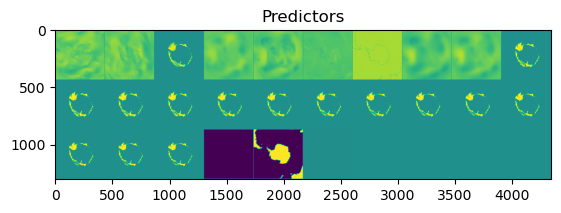

In [5]:
img = torchvision.utils.make_grid(x[[0]].transpose(0, 1), nrow=10)[0]
plt.title("Predictors")
plt.imshow(img)
plt.show()

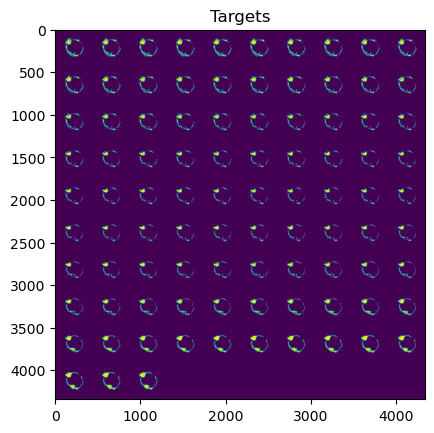

In [6]:
img = torchvision.utils.make_grid(y[[0]].transpose(0, 1), nrow=10)[0]
plt.title("Targets")
plt.imshow(img)
plt.show()

In [7]:
class ClassConditionedUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
        self.model = UNet2DModel(
            sample_size=432,  # the target image resolution
            in_channels=2,  # target channels + input channels
            out_channels=1,  # target channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
                "DownBlock2D",  
                "DownBlock2D",  # a ResNet downsampling block with spatial self-attention
            ),
            up_block_types=(
                "UpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",
                "UpBlock2D",  # a regular ResNet upsampling block
            ),
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, sample, t, condition):

        # Net input is now sample (noised y) and condition concatenated together along dimension 1
        net_input = torch.cat((sample, condition), 1)  # (bs, 93+26, 432, 432)

        # Feed this to the UNet alongside the timestep and return the prediction
        return self.model(net_input, t).sample  # (bs, 93, 432, 432)

In [8]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

  0%|          | 0/731 [00:00<?, ?it/s]

 18%|█▊        | 128/731 [07:49<36:49,  3.66s/it]3.25s/it, loss=0.0224, step=128] 

Finished epoch 0. Average of the last 100 loss values: 0.009900


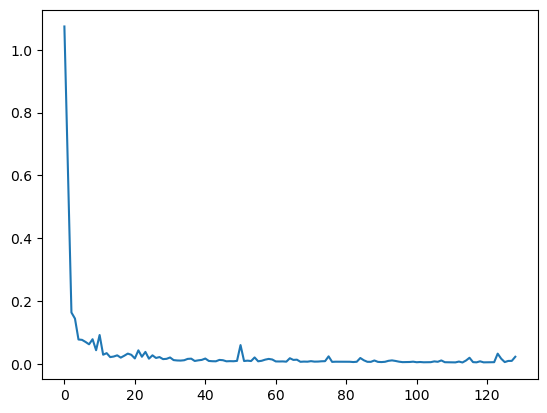

In [9]:
# @markdown Training loop (10 Epochs):

# How many runs through the data should we do?
n_epochs = 1

# Our network
net = ClassConditionedUNet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
global_step = 0
for epoch in range(n_epochs):

    progress_bar = tqdm(total=len(train_dataloader))
    progress_bar.set_description(f"Epoch {epoch}")

    for x, y, _ in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device)
        y = y.to(device)
        x = x[:, [2], :, :]  # select t=-1 ice as predictor
        y = y[:, [0], :, :]  # select t=1 ice as target
        noise = torch.randn_like(y)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_y, timesteps, x)  # Note that we pass in the condition x

        # Calculate the loss
        loss = loss_fn(pred, noise)  # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

        # log tqdm
        progress_bar.update(1)
        logs = {
            "loss": loss.detach().item(),
            "step": global_step
        }
        progress_bar.set_postfix(**logs)
        global_step += 1
        if global_step > 128:
            break

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:]) / 100
    print(f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}")

# View the loss curve
plt.plot(losses)

In [10]:
x.device

device(type='cuda', index=0)

In [11]:
# Prepare random y to start from, plus some desired conditions x
x, y, _ = next(iter(train_dataloader))  # will already be loaded
x = x[:, [2], :, :]  # select t=-1 ice as predictor
y = y[:, [0], :, :]  # select t=1 ice as target
x = x.to(device)
y = y.to(device)
noisy_y = torch.randn(4, 1, 432, 432).to(device)

# Sampling loop
noise_scheduler.set_timesteps(50)
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(noisy_y, t, x)  # Again, note that we pass in our labels y

    # Update sample with step
    noisy_y = noise_scheduler.step(noisy_y, t, x).prev_sample

50it [00:42,  1.18it/s]


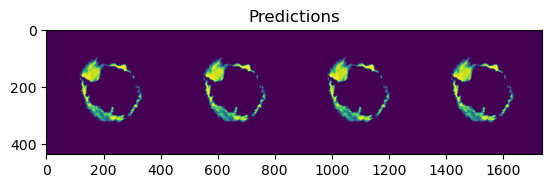

In [12]:
# Show the predictions
img = torchvision.utils.make_grid(noisy_y.cpu())[0]
plt.title("Predictions")
plt.imshow(img)
plt.show()

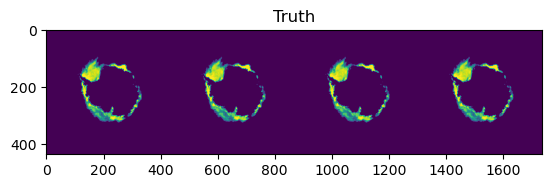

In [13]:
# Show the targets
img = torchvision.utils.make_grid(y.cpu())[0]
plt.title("Truth")
plt.imshow(img)
plt.show()

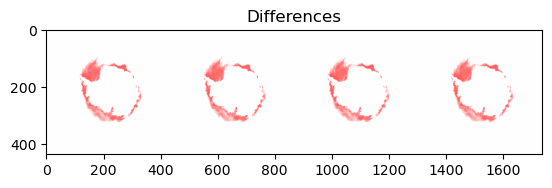

In [14]:
# Show the differences
diffs = y - noisy_y
img = torchvision.utils.make_grid(diffs.cpu())[0]
plt.title("Differences")
plt.imshow(img, cmap="bwr", vmin=-0.01, vmax=0.01)
plt.show()